The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-tvm
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/tvm-0.6.dev0-cp36-cp36m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/topi-0.6.dev0-py3-none-any.whl


# Packed Convolution

:label:`ch_packed_conv_cpu`


We observed in :numref:`ch_conv_cpu` that the performance degrades when increasing the channel size for the convolution operator. In this section, we will consider tiling the channel axes and packing the data to improve the performance.

In [1]:
import d2ltvm
import numpy as np
import tvm

target = 'llvm -mcpu=skylake-avx512'

## Packing Data and Weight

In :numref:`ch_conv_cpu`, we first tiled the width and height axes and then moved the inner axes as the innermost dimensions during computing. It's the same idea to tile the channels. But we do one additional step to actually move the data in the inner channel loop to the last dimension, i.e. do data layout transformation. So we pay the data movement cost once, while improving the data accessing performance significantly.

The following code block splits the channel dimension and move the data in NumPy.

In [2]:
c, n, tc = 4, 2, 2  # channel, height/width, and tiling size
x = np.arange(c*n*n).reshape((c, n, n)).astype('float32')
print('input shape', x.shape, '\n', x)
y = x.reshape(c//tc, n, n, tc).transpose(0, 2, 3, 1)
print('packed shape', y.shape, '\n', y)


input shape (4, 2, 2) 
 [[[ 0.  1.]
  [ 2.  3.]]

 [[ 4.  5.]
  [ 6.  7.]]

 [[ 8.  9.]
  [10. 11.]]

 [[12. 13.]
  [14. 15.]]]
packed shape (2, 2, 2, 2) 
 [[[[ 0.  4.]
   [ 1.  5.]]

  [[ 2.  6.]
   [ 3.  7.]]]


 [[[ 8. 12.]
   [ 9. 13.]]

  [[10. 14.]
   [11. 15.]]]]


Now let's implement the pack computation in TVM.

In [3]:
def conv_pack(oc, ic, nh, nw, kh, kw, ph, pw, toc, tic):
    """Pack data and weight for convolution

    oc, ic : output and input channels
    nh, nw : input width and height
    kh, kw : kernel width and height
    ph, pw : height and width padding
    toc, tic : the tiling sizes of the output and input channels
    """
    X = tvm.placeholder((ic, nh, nw), name='X')
    K = tvm.placeholder((oc, ic, kh, kw), name='K')
    PaddedX = d2ltvm.padding(X, ph, pw) if ph * pw != 0 else X
    # pack X and K
    assert ic % tic == 0 and oc % toc == 0
    PackedX = tvm.compute(
        (ic//tic, nh+ph*2, nw+pw*2, tic),
        lambda ic_out, x, y, ic_in: PaddedX[ic_out*tic + ic_in, x, y],
        name='PackedX')
    PackedK = tvm.compute(
        (oc//toc, ic//tic, kh, kw, tic, toc),
        lambda oc_out, ic_out, x, y, ic_in, oc_in: K[
            oc_out*toc + oc_in, ic_out*tic + ic_in, x, y],
        name='PackedK')
    return X, K, PaddedX, PackedX, PackedK

Verify the results by re-implementing the previous example.

In [4]:
X, _, _, PackedX, _ = conv_pack(c, c, n, n, 1, 1, 0, 0, tc, tc)
mod = tvm.build(tvm.create_schedule(PackedX.op), [X, PackedX])
packed_x = tvm.nd.array(np.empty((c//tc, n, n, tc), dtype='float32'))
mod(tvm.nd.array(x), packed_x)
np.testing.assert_equal(packed_x.asnumpy(), y)

Of note, in :numref:`ch_conv` we defined the layout of the input data to be `NCHW`. For the packed data `PackedX` here, we follow the convention defined in :cite:`Liu.Wang.Yu.ea.2019` to define its layout as `NCHW[x]c`, where `x` describes the size of `c`, which is 2 (the value of `tc` above) in this case.

## Computation

Since we changed the data layout, we need to re-implement the convolution computation accordingly.

In [5]:
def conv(oc, ic, nh, nw, kh, kw, ph, pw, sh, sw, toc, tic):
    """2-D conv

    oc, ic : output and input channels.
    nh, nw : input width and height
    kh, kw : kernel width and height
    ph, pw : height and width padding
    sh, sw : height and width strides
    toc, tic : the tiling sizes of output channel and input channel
    """
    X, K, PaddedX, PackedX, PackedK = conv_pack(
        oc, ic, nh, nw, kh, kw, ph, pw, toc, tic)
    # reduction axes
    ric_in = tvm.reduce_axis((0, tic), name='ric_in')
    ric_out = tvm.reduce_axis((0, ic//tic), name='ric_out')
    rkh = tvm.reduce_axis((0, kh), name='rkh')
    rkw = tvm.reduce_axis((0, kw), name='rkw')
    # output height and weights
    oh = d2ltvm.conv_out_size(nh, kh, ph, sh)
    ow = d2ltvm.conv_out_size(nw, kw, pw, sw)
    # Compuated Y in the packed layout
    PackedY = tvm.compute(
        (oc//toc, oh, ow, toc),
        lambda oc_out, x, y, oc_in: tvm.sum(
            PackedX[ric_out, x*sh+rkh, y*sw+rkw, ric_in] *
            PackedK[oc_out, ric_out, rkh, rkw, ric_in, oc_in],
            axis=[ric_out, rkh, rkw, ric_in]), name='Y')
    # Unpack the result
    Y = tvm.compute((oc, oh, ow),
                    lambda oc, x, y: PackedY[oc//toc, x, y, oc%toc],
                    name='Y')
    return X, K, Y, PaddedX, PackedX, PackedK, PackedY

Let's compile it using the default scheduling and compute the results.

In [6]:
oc, ic, n, k, p, s, toc, tic = 4, 6, 12, 3, 1, 1, 2, 3
X, K, Y, _, _, _, _ = conv(oc, ic, n, n, k, k, p, p, s, s, toc, tic)
mod = tvm.build(tvm.create_schedule(Y.op), [X, K, Y])

data, weight, out = d2ltvm.get_conv_data(oc, ic, n, k, p, s, tvm.nd.array)
mod(data, weight, out)

And then verify the result.

In [7]:
data, weight, bias, out_mx = d2ltvm.get_conv_data_mxnet(oc, ic, n, k, p, s)
d2ltvm.conv_mxnet(data, weight, bias, out_mx, k, p, s)
np.testing.assert_allclose(out_mx[0].asnumpy(), out.asnumpy(), atol=1e-5)

## Schedule

The optimization strategy here is similar to :numref:`ch_conv_cpu`. The major differences are

1. the innermost axis is the inner axis split from the output channel because the elements have already sit on the last dimension after packing.
2. We only split the width dimension instead of both width and height dimensions.
3. We need to schedule the packing and unpacking computations as well.

In [8]:
# tiling sizes for output channel, input channel, and width
toc, tic, tw = 16, 16, 4

def cached_block(oc, ic, n, k, p, s):
    X, K, Y, PaddedX, PackedX, PackedK, PackedY = conv(
        oc, ic, n, n, k, k, p, p, s, s, toc, tic)
    s = tvm.create_schedule(Y.op)
    CachedY = s.cache_write(PackedY, 'local')
    oc_out, h, w, oc_in = s[PackedY].op.axis
    oc_out_h = s[PackedY].fuse(oc_out, h)
    # Parallel on the first two dimensions oc_out and h
    s[PackedY].parallel(oc_out_h)
    # Optimize the computation of a cached output block
    w_out, w_in = s[PackedY].split(w, factor=tw)  # Split the columns
    s[CachedY].compute_at(s[PackedY], w_out)
    _, _, cw, oc_in = CachedY.op.axis
    ric_out, rkh, rkw, ric_in = CachedY.op.reduce_axis
    s[CachedY].reorder(ric_out, rkh, rkw, ric_in, cw, oc_in)
    s[CachedY].unroll(ric_in)
    s[CachedY].unroll(cw)
    s[CachedY].vectorize(oc_in)
    # Schedule the padding by adding thread-level parallelism
    if PaddedX != X:
        s[PaddedX].parallel(PaddedX.op.axis[0])
    # Optimize the packing of X and K
    s[PackedX].parallel(s[PackedX].fuse(*PackedX.op.axis[0:2]))
    s[PackedX].unroll(PackedX.op.axis[-1])
    s[PackedK].parallel(s[PackedK].fuse(*PackedK.op.axis[0:2]))
    s[PackedK].unroll(PackedK.op.axis[-1])
    # Optimize the unpacking of Y
    s[Y].parallel(s[Y].fuse(*Y.op.axis[0:2]))
    s[Y].unroll(Y.op.axis[-1])
    return s, (X, K, Y)

s, args = cached_block(32, 32, 64, 3, 1, 1)
# Uncomment the following line to see the long
# psuedo codes because of unrolling.
# tvm.lower(s, args, simple_mode=True)

Let's benchmark then same workloads as :numref:`ch_conv_cpu` and compare to our MXNet baseline. As you can see, the results are significantly improved.

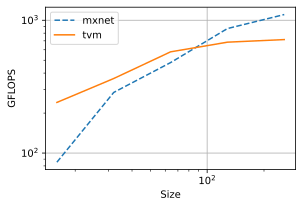

In [9]:
channels = 2**np.arange(4, 9)
sizes = [(int(c), 64, 3) for c in channels] # a list of (c, n, k)
tvm_gflops = d2ltvm.bench_conv_tvm(cached_block, sizes, target)
mxnet_gflops = d2ltvm.bench_conv_mxnet(sizes)
d2ltvm.plot_gflops(channels, [mxnet_gflops, tvm_gflops], ['mxnet', 'tvm'])

## Summary

- We often tile input and output channels to for better cache efficiency and pack data accordingly.

## Exercises

- What if the number of channels cannot be divided by the tiling size?
- Try different tiling sizes.